In [1]:
from google.colab import drive
drive.mount("/content/drive")

MessageError: ignored

In [ ]:
import tensorflow as tf
import re
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1138953882912001270
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10573660444689622764
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


In [ ]:
BATCH_SIZE = 128

Step 1 : DataSet

In [ ]:
%%capture
!pip install -U spacy

In [ ]:
%%capture
!pip install tensorflow

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/NLP Project/Data/T1_Text_Summarization_English_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NLP Project/Data/T1_Text_Summarization_English_test.csv")


In [ ]:
len(train_df)

10052

In [ ]:
len(test_df)

2513

In [ ]:
train_df

,Heading,Summary,Article,id
0,India opposes China's Belt and Road Initiative...,The name of all member countries except India ...,"At SCO, India refuses to back China's Belt and...",0
1,"UN urges for maximum restraint, invokes Simla ...","Pakistan termed the Indian action as ""unilater...","UN chief invokes Shimla Agreement, calls for '...",1
2,"China, Pak to finalise deal to develop SEZ und...","""The agreement will be finalised between Khybe...","China, Pak to finalise deal to develop SEZ und...",2
3,"Covaxin effectively neutralises both Alpha, De...",The top health research institute said that an...,"Covaxin effectively neutralises both Alpha, De...",3
4,"Top White House officials buried CDC report, r...",The decision to shelve detailed advice from th...,"In this April 22, 2020, file photo President D...",4
...,...,...,...,...
10047,Covid-19 vaccine not likely to be available by...,It was not likely for a coronavirus vaccine to...,Covid-19 vaccine not likely to be available by...,10047
10048,"Jill Biden visits Europe, will meet with Ukrai...","After flying overnight from Washington, the fi...",US First lady Jill Biden meets U.S. troops dur...,10048
10049,Coronaviurus: 29 foreigners infected by in Chi...,Twenty-nine foreign nationals in China were in...,Coronaviurus: 29 foreigners infected by in Chi...,10049
10050,Pakistan Defence’s Twitter account suspended f...,"On Saturday, numerous Indian Twitter users com...",Pakistan was yet again embarrassed on Saturday...,10050


In [ ]:
import re
p = re.split(r"\*",train_df.iloc[1].Article)

Step 2: clean the Data

In [ ]:
print(train_df.iloc[1].Summary)

Pakistan termed the Indian action as "unilateral and illegal", and said it will take the matter to the UN Security Council. "The Secretary-General has been following the situation in Jammu and Kashmir with concern and makes an appeal for maximum restraint," Guterres' spokesman Stephane Dujarric said.


In [ ]:
def preprocess(row):

      # row = re.sub('<\s*script[^>]*>.*?<\s*/\s*script\s*>',"",row)
      splits = re.split(r"\*", row)## removing the javascript garbage
      row = splits[0]
      row = re.sub("(\\t)", " ", str(row)).lower()
      row = re.sub("(\\r)", " ", str(row)).lower()
      row = re.sub("(\\n)", " ", str(row)).lower()

      # Remove _ if it occurs more than one time consecutively
      row = re.sub("(__+)", " ", str(row)).lower()

      # Remove - if it occurs more than one time consecutively
      row = re.sub("(--+)", " ", str(row)).lower()

      # Remove ~ if it occurs more than one time consecutively
      row = re.sub("(~~+)", " ", str(row)).lower()

      # Remove + if it occurs more than one time consecutively
      row = re.sub("(\+\++)", " ", str(row)).lower()

      #remove slashes
      row = re.sub(r"\\", "", str(row)).lower()

      #remove apostrophe
      row = re.sub("'","", str(row)).lower()

      # Remove the characters - <>()|&©ø"',;?~*!
      row = re.sub(r"[<>()|&©ø\[\]\'\"~*]", " ", str(row)).lower()

      # Remove mailto:
      row = re.sub("(mailto:)", " ", str(row)).lower()

      # Remove \x9* in text
      row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

      #remove unicode space symbols
      row = re.sub(r'\\xa0', r' ', str(row)).lower()

      # Replace INC nums to INC_NUM
      row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

      # Replace CM# and CHG# to CM_NUM
      row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

      # Replace any url to only the domain name
      try:
          url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
          repl_url = url.group(3)
          row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
      except:
          pass

      # Remove multiple spaces
      row = re.sub("(\s+)", " ", str(row)).lower()

      # Remove the single character hanging between any two spaces
      row = re.sub("(\s+.\s+)", " ", str(row)).lower()
      

      return row

In [ ]:
train_df.columns

Index(['Heading', 'Summary', 'Article', 'id'], dtype='object')

In [ ]:
processed_text_train = train_df['Article'].apply(preprocess)
processed_summary_train = train_df['Summary'].apply(preprocess)

processed_text_test = test_df['Article'].apply(preprocess)

In [ ]:
example = p[0]
example = example.split(" ")
for i in range(len(example)):
  tok = example[i]
  if example[-1]=='.':
    q = tok[:-1]
    if '.' in q:
      r = example[i].split('.')
      example[i] = ''.join(r)
  if ".." in example[i]:
    r = example[i].split('.')
    r = ''.join(r)
    example[i] = r

example = ' '.join(example)
print(example)

Asmita says hello to ra's al-ghul


Load the data as batches using the pipe() method provided by spaCy. This ensures that all pieces of text and summaries possess the string data type.

In [ ]:
import spacy
from time import time

# Process text as batches and yield Doc objects in order
text_train = [str(doc) for doc in processed_text_train]

summary_train = [ str(doc)  for doc in processed_summary_train]

text_test = [str(doc) for doc in processed_text_test]

In [ ]:
text_test[0]

'how worrying is the variant first seen in india?for the first time in months, people across england are meeting indoors at pubs, restaurants, cinemas, gyms and elsewhere as coronavirus rules were relaxed this week. but prime minister boris johnson warned britons to be cautious and some of the scientists advising him say restrictions might need to be reimposed quickly because of worrying variant first detected in india.heres look at what we know and dont know about the variant:what is this variant?the covid-19 variant first identified in india has been classified as “variant of concern” by britain and the world health organisation, meaning there is some evidence that it spreads more easily between people, causes more severe disease, or might be less responsive to treatments and vaccines.“the absolute numbers of cases of the variant in the uk remain quite small, but the growth rate is quite high,” said nick loman, professor of microbial genomics at the university of birmingham.to date, 

In [ ]:
text_train[0]

'at sco, india refuses to back chinas belt and road projectindia on sunday refused to back chinas ambitious belt and road initiative at the sco summit with prime minister narendra modi asserting that any mega connectivity project must respect sovereignty and territorial integrity of the countries. india was the only country in the eight-nation shanghai cooperation organisation grouping to oppose the bri project by china. declaration signed by leaders of the shanghai cooperation organisation sco countries, including modi, at the end of two-day summit of the bloc said russia, pakistan, kazakhstan, uzbekistan, kyrgyzstan and tajikistan have been reaffirming their support for chinas belt and road initiative bri .related stories sco summit: president xi accepts pm modis invitation for informal summit in india in 2019 pm modi at sco summit 2018: connectivity with neighbourhood and in sco region india’s prioritypm modi, pak pres hussain shake hands at sco summitsco summit: pm modi calls for r

In [ ]:
summary_train[0]

'the name of all member countries except india figured in the paragraph of the joint declaration endorsing beijings multi-billion dollar project.'

### Step 3: Determining the Maximum Permissible Sequence Lengths

In [ ]:
train_df['cleaned_text'] = pd.Series(text_train)
train_df['cleaned_summary'] = pd.Series(summary_train)

clean the test

In [ ]:
test_df['cleaned_text'] = pd.Series(text_test)

Plot a graph to determine the frequency ranges tied to the lengths of text and summary, 
i.e., determine the range of length of words where the maximum number of texts and summaries fall into.

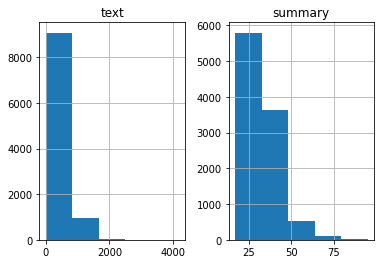

In [ ]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in train_df['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in train_df['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

Since maximum of the texts fall has upto 2000 token length and summary has upto 50 .

Hence maxmimum source length = 2000
Maximum Target length = 50

In [ ]:
# Model to summarize the text between 0-2000 words for Summary and 0-50 words for Text
max_text_len = 2000
max_summary_len = 100

### Step 4: Selecting source and summary that fall within the range

In [ ]:
# Select the Summaries and Text which fall below max length 

import numpy as np

cleaned_text = np.array(train_df['cleaned_text'])
cleaned_summary= np.array(train_df['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')


post_pre.head(2)

,text,summary
0,"at sco, india refuses to back chinas belt and ...",sostok the name of all member countries except...
1,"un chief invokes shimla agreement, calls for m...",sostok pakistan termed the indian action as un...


In [ ]:
post_pre

,text,summary
0,"at sco, india refuses to back chinas belt and ...",sostok the name of all member countries except...
1,"un chief invokes shimla agreement, calls for m...",sostok pakistan termed the indian action as un...
2,"china, pak to finalise deal to develop sez und...",sostok the agreement will be finalised betwee...
3,"covaxin effectively neutralises both alpha, de...",sostok the top health research institute said ...
4,"in this april 22, 2020, file photo president d...",sostok the decision to shelve detailed advice ...
...,...,...
10020,covid-19 vaccine not likely to be available by...,sostok it was not likely for coronavirus vacci...
10021,us first lady jill biden meets u.s. troops dur...,"sostok after flying overnight from washington,..."
10022,coronaviurus: 29 foreigners infected by in chi...,sostok twenty-nine foreign nationals in china ...
10023,pakistan was yet again embarrassed on saturday...,"sostok on saturday, numerous indian twitter us..."


Step 5: Tokenizing the Text

In [ ]:
train_df.columns

Index(['Heading', 'Summary', 'Article', 'id', 'cleaned_text',
       'cleaned_summary'],
      dtype='object')

In [ ]:
#x_tr = train_df['cleaned_text']

#y_tr = train_df['cleaned_summary']
x_tr = post_pre['text']
y_tr = post_pre['summary']

In [ ]:
list(train_df['cleaned_summary'])[0]

'the name of all member countries except india figured in the paragraph of the joint declaration endorsing beijings multi-billion dollar project.'

In [ ]:
x_test = test_df['cleaned_text']

In [ ]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')

In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq,  maxlen=max_summary_len, padding='post')

In [ ]:
y_tr

array([[   3,    1,  981, ...,    0,    0,    0],
       [   3,   35, 1843, ...,    0,    0,    0],
       [   3,    1,  506, ...,    0,    0,    0],
       ...,
       [   3, 3923, 1028, ...,    0,    0,    0],
       [   3,    8,  108, ...,    0,    0,    0],
       [   3,  278,   26, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#for test data

x_test_seq = x_tokenizer.texts_to_sequences(x_test)

# Pad zero upto maximum length
x_test = pad_sequences(x_test_seq,  maxlen=max_text_len, padding='post')

#y_test_seq = y_tokenizer.texts_to_sequences(y_test)

# Pad zero upto maximum length
#y_test = pad_sequences(y_test_seq,  maxlen=max_summary_len, padding='post')

In [ ]:
#len of the vocab in text
x_voc = len(x_tokenizer.word_counts)+1


In [ ]:
#len of vocab in summary
y_voc = len(y_tokenizer.word_counts)+1

## Building the model

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
latent_dim = 264
embedding_dim = 128


# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0,activation = 'tanh',recurrent_activation = 'sigmoid',unroll = False,use_bias = True)

(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0,activation = 'tanh',recurrent_activation = 'sigmoid',unroll = False,use_bias = True)

(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0,activation = 'tanh',recurrent_activation = 'sigmoid',unroll = False,use_bias = True)

(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,recurrent_dropout=0,activation = 'tanh',recurrent_activation = 'sigmoid',unroll = False,use_bias = True)                   

(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 2000)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 2000, 128)    10503680    ['input_21[0][0]']               
                                                                                                  
 lstm_16 (LSTM)                 [(None, 2000, 264),  415008      ['embedding_8[0][0]']            
                                 (None, 264),                                                     
                                 (None, 264)]                                                     
                                                                                           

### Step 8 : Training the Model

In [ ]:
opt = Adam(learning_rate=0.0001)

In [ ]:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
y_tr.shape

(10025, 100)

In [ ]:
type(y_tr)

numpy.ndarray

In [ ]:
a = np.array([[1,2,3], [4,5,6]])
a[:, :-1]

array([[1, 2],
       [4, 5]])

In [ ]:
y_tr.shape

(10025, 100)

In [ ]:
history = model.fit(
    
    [x_tr, y_tr[:, :-1]],
    
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    
    epochs=2,
    
    #callbacks=[es],
    
    batch_size= BATCH_SIZE,
    )

Epoch 1/2
79/79 [==============================] - 123s 2s/step - loss: 7.4290
Epoch 2/2
79/79 [==============================] - 126s 2s/step - loss: 3.7096


In [ ]:
history

In [ ]:
model.save('enc_dec_plain_500_epoch_22_sept')

### Plotting the loss

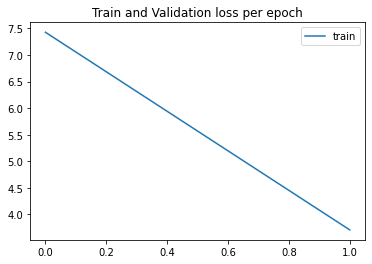

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.title("Train and Validation loss per epoch")
pyplot.legend()
pyplot.show()

### Step 9: Generating Predictions

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

Building inference models

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

Decode Seq : Accepts input texts and outputs the predicted summary

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])
      
        # Sample a token
        sampled_token_index = 1+ np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    
    newString = ''
    
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    
    newString = ''
    
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

##### Generate summary from train data

In [ ]:
# df_of_gen_sum_train = {'Review':[] , 'Original summary':[] , 'Predicted summary':[],}

# for i in range(0, 19):
#     df_of_gen_sum_train['Review'].append(seq2text(x_tr[i]))
#     df_of_gen_sum_train['Original summary'].append(seq2text(y_tr[i]))
#     df_of_gen_sum_train['Predicted summary'].append(seq2text(decode_sequence(x_tr[i].reshape(1,
#             max_text_len))))
    
    

##### Predicting on train Data

In [ ]:
target_word_index['sostok']

2

In [ ]:
for i in range(0, 19):
    
    print (f'Review:{seq2text(x_tr[i])}\n')
    
    #print (f'Original summary:{(y_tr[i])}\n')
    
    print (f'Predicted summary:{decode_sequence(x_tr[i].reshape(1,max_text_len))} \n')
    
    print ("\n \n")

#### predicting on test data

In [ ]:
for i in range(0, 5):
    
    print (f'Review:{seq2text(x_test[i])}\n')
    
    #print (f'Original summary:{seq2summary(y_test[i])}\n')
    
    print (f'Predicted summary:{decode_sequence(x_test[i].reshape(1,max_text_len))} \n')
    
    print ("\n \n")

Review:how worrying is the variant first seen in india for the first time in months people across england are meeting indoors at pubs restaurants cinemas gyms and elsewhere as coronavirus rules were relaxed this week but prime minister boris johnson warned britons to be cautious and some of the scientists advising him say restrictions might need to be reimposed quickly because of worrying variant first detected in india heres look at what we know and dont know about the variant what is this variant the covid 19 variant first identified in india has been classified as “variant of concern” by britain and the world health organisation meaning there is some evidence that it spreads more easily between people causes more severe disease or might be less responsive to treatments and vaccines “the absolute numbers of cases of the variant in the uk remain quite small but the growth rate is quite high ” said nick professor of microbial genomics at the university of birmingham to date there have 

In [ ]:
output_tokens
#reverse_target_word_index.keys()

NameError: ignored